# System MTF Budget: Satellite Example

## Introduction

The Modulation Transfer Function (MTF) essentially describes the ability of an optical system to resolve fine detail. However, the system MTF is not limited to optics or the detector. Anything impacting the MTF (or, in practical terms blurring or smearing the image) should be accounted for. The final system MTF is a combination of all such factors.

In this example we will compute a sample MTF budget for the French high-res satellite Pléiades.

Note that this example uses a simple circular full aperture for Pléiades (to not add to an already long notebook). A more detailed aperture and optics MTF definition is presented [here](optics_aperture_psf.ipynb).

Sources for the Pléiades data (see also other references at the end):

- [ESA Pléiades page](https://earth.esa.int/eogateway/missions/pleiades#instruments-section)
- [eoPortal Pléiades page](https://www.eoportal.org/satellite-missions/pleiades#hiri-high-resolution-imager)

## Loading the Imager Parameters

An imager is made up of three parts: Optics, Detector and (optionally) Read-out/Write Electronics. We load the configuration files for each part and initialise the `Imager` object.

In [26]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

from astropy.visualization import quantity_support

quantity_support()

%matplotlib inline

from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("always")

In [27]:
from pathlib import Path

from opticks.imager_model.detector import Channel
from opticks.imager_model.imager import Imager

# print(f"current working directory: {Path.cwd()}")

file_directory = Path("docs", "examples", "sample_sat_pushbroom")
optics_file_path = file_directory.joinpath("optics.yaml")
detector_file_path = file_directory.joinpath("pan_detector.yaml")
rw_electronics_file_path = file_directory.joinpath("rw_electronics.yaml")

# check whether input files exist
print(
    f"optics file:  [{optics_file_path}] (file exists:  {optics_file_path.is_file()})"
)
print(
    f"detector file:  [{detector_file_path}] (file exists:  {detector_file_path.is_file()})"
)
print(
    f"RW electronics file:  [{rw_electronics_file_path}] (file exists:  {rw_electronics_file_path.is_file()})"
)

# Init imager object
imager = Imager.from_yaml_file(
    optics_file_path, detector_file_path, rw_electronics_file_path
)

optics file:  [docs/examples/sample_sat_pushbroom/optics.yaml] (file exists:  True)
detector file:  [docs/examples/sample_sat_pushbroom/pan_detector.yaml] (file exists:  True)
RW electronics file:  [docs/examples/sample_sat_pushbroom/rw_electronics.yaml] (file exists:  True)


In [28]:
# shorthands
optics = imager.optics
detector = imager.detector
rw_electronics = imager.rw_electronics

# select the PAN channel
band_id = "pan"
channel: Channel = detector.params.channels.all[band_id]

## Imager MTF

### Overview

The imager comprises the optics and the detector. The optics and detector MTFs can be plotted for the increasing input line frequencies. Usually the optics MTF comes out of Zemax computations or lab measurements. 

Each of these is MTF components is encapsulated in an `MTF_Model_1D` object. The object can be queried for `mtf_value()` for an input line frequency. In this example we will use the ideal optical MTF (given by the `MTF_Model_1D.ideal_optics()` default model). We will then evaluate it for 100 intermediate line frequencies, all the way to the spatial cutoff frequency, where (by definition) no more detail can be resolved by the optics. Similar to the Optical MTF, the Detector MTF will be calculated via the `MTF_Model_1D.detector_sampling()` function. On the other hand, the detector Nyquist frequency determines the maximum theoretical resolution that can be obtained from the imager.

It should be taken into account that the spatial cutoff frequency is also a function of the wavelength and Pléiades PAN works in the range 480 to 820 nm.

Note the widely used bands:

- blue: 450-485 nm
- green: 500-565 nm
- red: 625-750 nm
- nir: 780-2500 nm

In this example we will evaluate the Optics MTF at the limits as well as the middle of the PAN range. Then we will compute the Detector MTF and finally we will combine the 650 nm Optics MTF with the Detector MTF to obtain the Imager MTF (at 650 nm).

### Wavelength Dependency of the Ideal Optical MTF

First we investigate the wavelength dependency of the MTF. For that we mark three wavelengths, the two extremes of Pléiades PAN range and the middle: 480 nm, 650 nm and 820 nm.

We will also plot the Detector Nyquist Limit to illustrate the bounds of the useful MTF.

In [29]:
import numpy as np

from opticks import u
from opticks.contrast_model.mtf import MTF_Model_1D

ref_wavelength = [480, 650, 820] * u.nm

# Generate the optics MTF data for the wavelengths
cutoff_freq = optics.spatial_cutoff_freq(ref_wavelength)
line_freq_unit = cutoff_freq.unit
input_line_freq = np.linspace(0.0, cutoff_freq, 100).transpose()

# Generate the detector Nyquist limit
nyq_freq = channel.nyquist_freq(with_binning=True)

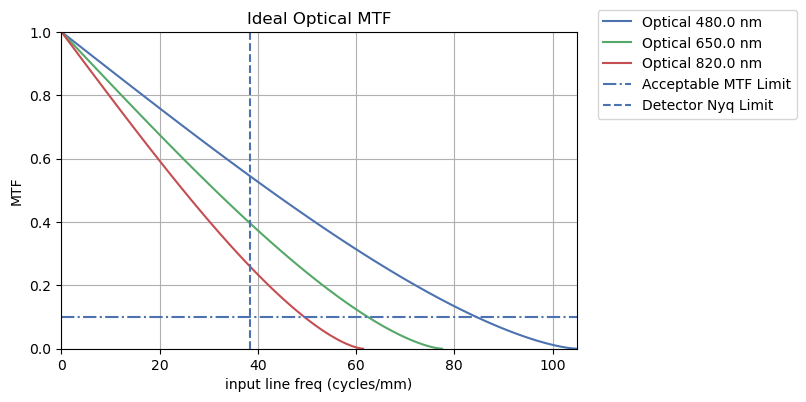

In [30]:
from opticks.contrast_model.mtf import MTF_Plot_1D

# generate the mtf data models
mtf_plot_data = {}

for wvl in ref_wavelength:
    mtf_plot_data[f"Optical {wvl}"] = MTF_Model_1D.ideal_optics(wvl, optics)

# set plot style
plt.style.use("seaborn-v0_8-deep")

# plot the MTF data
# -----------------

# populate the mtf plot with the models
ideal_opt_mtf_plot = MTF_Plot_1D(input_line_freq, mtf_plot_data, nyq_limit=nyq_freq)

# set MTF plot style tweaks
ideal_opt_mtf_plot.set_plot_style(
    x_max=cutoff_freq.max(),
    title="Ideal Optical MTF",
)

From the plot, certain observations can be made:
- As the PAN band has a very broad frequency range, the incoming light wavelength impacts the MTF performance very significantly. At the blue limit of the band (480 nm), detail is resolved significantly better than the red in the middle of the band (650 nm) and the near-infrared limit at the end (820 nm).
- The pixel size limits the MTF (Nyquist limit) and does not allow input line frequencies above approximately 38 line pairs/mm, even though the optics can resolve detail for higher input line frequencies.
- While not a hard rule, an System MTF of 0.1 at the Nyquist Limit is desired. This ensures that the fine detail in the scene is resolved at an adequate sharpness. In this example, the Imager MTF (at 650 nm) is around 0.25. This is a good value, but it should be kept in mind that the optics are assumed ideal and the computed value can be called the "Static MTF". On the satellite, it will be subject to other effects due to several sources of motion, degrading the image quality further.

### Imager MTF with Optical Aberrations

While this is the ideal optical MTF, in reality aberrations would introduce a degradation. For a satellite like Pléiades, a Wavefront Error ($W_{RMS}$) of 5% of the wavelength is a reasonable first guess. This can be used to generate an approximate aberrated optical MTF. That said, the central obstruction due to the secondary mirror is not taken into account and could in reality be significant.

For the remainder of the computations we will focus on the midrange wavelength (650 nm).

In [31]:
# Select midrange wavelength
ref_wavelength_mid = channel.centre_wavelength
cutoff_freq_mid = optics.spatial_cutoff_freq(ref_wavelength_mid)
input_line_freq_mid = (
    np.linspace(0.0, cutoff_freq_mid.value, 100) * cutoff_freq_mid.unit
)


# Generate the midrange ideal optical MTF model and values
mtf_ideal_opt_mid = MTF_Model_1D.ideal_optics(ref_wavelength_mid, optics)

# Generate the midrange aberrated optical MTF model and values
w_rms = 0.05
mtf_aberr_opt_mid = MTF_Model_1D.emp_model_aberrated_optics(
    ref_wavelength_mid, w_rms, optics
)

# Generate the detector MTF data (use 650 nm input line data)
pixel_pitch = channel.pixel_pitch(with_binning=True)
mtf_det_sampling_model = MTF_Model_1D.detector_sampling(pixel_pitch)

# Generate the imager MTF model and data at 650 nm (imager = aberrated optics x detector)
mtf_model_imager_mid = MTF_Model_1D.combined(mtf_aberr_opt_mid, mtf_det_sampling_model)

The data has been generated for the ideal optical MTF, aberrated optical MTF and the detector MTF, as well as the combined imager MTF, which uses the aberrated optics model.

Imager MTF : 23.208% (at Nyq Limit 38.46 cycle / mm and 650.0 nm)


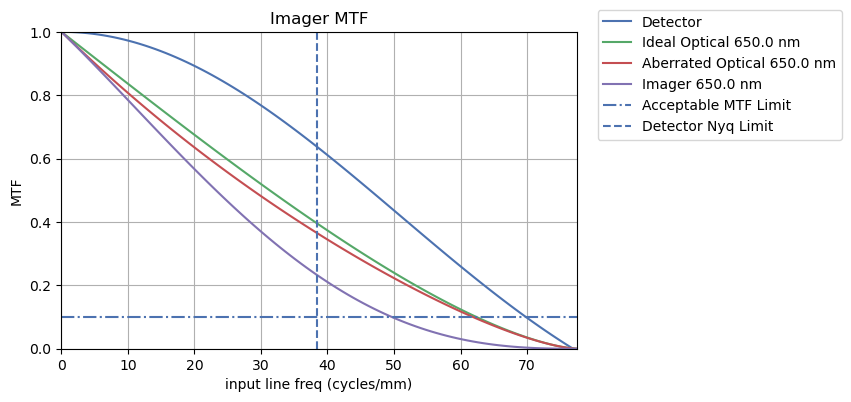

In [32]:
# plot the MTF data
# -----------------

mtf_plot_list = {
    "Detector": mtf_det_sampling_model,  # detector MTF
    f"Ideal Optical {ref_wavelength_mid}": mtf_ideal_opt_mid,  # Ideal Optical MTF
    f"Aberrated Optical {ref_wavelength_mid}": mtf_aberr_opt_mid,  # Aberrated Optical MTF
    f"Imager {ref_wavelength_mid}": mtf_model_imager_mid,  # total imager MTF
}

# populate the mtf plot with the models
imager_mtf_plot = MTF_Plot_1D(input_line_freq_mid, mtf_plot_list, nyq_limit=nyq_freq)

# set MTF plot style tweaks
imager_mtf_plot.set_plot_style(x_max=input_line_freq_mid.max(), title="Imager MTF")

# plot the figure
# plt.show()

print(
    f"Imager MTF : {mtf_model_imager_mid.mtf_value(nyq_freq):.3%} (at Nyq Limit {nyq_freq:.4} and {ref_wavelength_mid})"
)

The first observation from the plot is that, at this small wavefront error, aberrations don't change Ideal Optics MTF significantly. On the other hand, the total Imager MTF is much lower than the pure Optical MTF, decreasing to about 0.25 at the detector Nyquist limit. Nevertheless, it is still above the acceptable limit. This is sometimes called the "Static MTF", because it is the theoretical MTF of the instrument at the lab conditions (assuming there are no vibration sources inside, such as a cryocooler). We will investigate the "Dynamic MTF" in the next section, where the motion of the camera introduces blurring and smearing.

Finally, another (fairly) useful metric is the Optical Q value. Particularly for this broad PAN band, it should be computed for different wavelengths to assess the overall quality.

In [33]:
# compute Q (for the three wavelengths)
q = imager.q_factor(ref_wavelength, band_id, with_binning=True)

print(f"Optical Q : {np.array_str(q, precision=5)}")

Optical Q : [0.73307 0.99269 1.25232]


When the Optical Q value can be computed for the three reference wavelengths (the limits and the middle of PAN), it can be observed that the middle 650 nm has a Q value that is practically equal to 1 and even the 820 nm edge wavelength has a Q value of 1.25.

## Dynamic MTF

### Overview

Dynamic MTF is the broad name given to multiple sources of image sharpness loss, commonly due to a "shaking" of the imager or a relative motion between the imager and the platform. The following MTF contributors will be computed:

1. Motion blur, or satellite motion with respect to the Earth during the exposure duration
2. Drift/smear due to slow satellite motion during the exposure duration
3. Jitter due to fast satellite motion during the exposure duration
4. Drift/smear due to slow satellite motion during the total TDI duration
5. Jitter due to fast satellite motion during the total TDI duration
6. Drift due to incorrect line rate

Item 1 is straightforward. Item 2 and 3 are computed at a single line exposure duration (or integration time). Each of these two items is the composite of multiple physical processes (for example attitude determination and control, microvibrations due to Reaction Wheels or Flexible Body Dynamics), that act at different timescales or frequencies. Generally, the frequency that divides the drift/smear contributions from jitter is the exposure duration in this case.

Items 4 and 5 are similar to Items 2 and 3, except the critical frequency that divides drift/smear and jitter is the total TDI column duration. Therefore, a relatively fast drift component for a single line can be a drift component for the total TDI column. Finally, Item 6 is also an artefact due to how TDI works.

There are other effects that are not taken into account here, such as the residual yaw error, which is due to the optimal choice of yaw steering angle can only be perfect for a single point on the detector (usually the centre).

When computing the dynamic MTF components, we will group them for along-track (ALT) and across-track (ACT), as they are different due to the dynamic processes involved.

We don't have the actual values from Pléiades, therefore we will make (hopefully reasonable) assumptions. The process here is more important than the values themselves.

### Motion Blur

We start with the Motion Blur model, which is a strictly ALT artefact. Basically, the blur extent is equal to the integration time ratio to the total line duration. If the integration time is half the line duration, then a 50% pixel size blur is reached.

In [34]:
timings = detector.params.timings

motion_blur_extent = timings.integration_duration / timings.frame_duration
print(f"single line duration : {timings.frame_duration:.4} ({timings.frame_rate:.6})")
print(f"actual integration duration : {timings.integration_duration:.4}")
print()
print(f"motion blur as percentage of pixel : {motion_blur_extent:.1%}")

mtf_model_mot_blur = MTF_Model_1D.motion_blur(pixel_pitch, motion_blur_extent)

single line duration : 0.1019 ms (9811.6 Hz)
actual integration duration : 0.03 ms

motion blur as percentage of pixel : 29.4%


### Single Line Drift/Smear and Jitter

The single line drift/smear is similar in principle to the Motion Blur, except it has both ALT and ACT components. For each, we sum the various sources and come up with a single number. Usually each source comes with its own angular velocity, which is then multiplied by the exposure duration to compute the its blur extent contributor. The contributors are summed in the RSS sense, as they can be in opposite directions.

For this exercise we will have only a couple of contributors: Control Moment Gyro (instead of Reaction Wheel) and Attitude Control. Particularly the CMG (or RW) vibrations introduce more than one component, but for simplicity we will assume a single overall or dominant drift. In the case of Pléiades, the CMG spin rate is around 70.9 to 78.4 Hz,which introduces a vibration at this frequency and will have harmonics at other frequencies, though the worst of these impacts are still too slow at the TDI frequency at about 1000 Hz.

Usually Flexible Body Dynamics are way too slow to have any effect at this duration.

In [35]:
# Sample values - Single image drift/smear
adcs_alt_ang_vel = 0.006 * u.deg / u.s
adcs_act_ang_vel = 0.005 * u.deg / u.s

rw_alt_ang_vel = 0.07 * u.deg / u.s
rw_act_ang_vel = 0.08 * u.deg / u.s

# Blur extent
ifov = imager.ifov(band_id, True).to(u.deg)
adcs_alt_extent = adcs_alt_ang_vel * timings.integration_duration / ifov
adcs_act_extent = adcs_act_ang_vel * timings.integration_duration / ifov

rw_alt_extent = rw_alt_ang_vel * timings.integration_duration / ifov
rw_act_extent = rw_act_ang_vel * timings.integration_duration / ifov

# Total blur extent
total_alt_extent = np.sqrt(adcs_alt_extent**2 + rw_alt_extent**2)
total_act_extent = np.sqrt(adcs_act_extent**2 + rw_act_extent**2)

# MTF Models in ALT and ACT
mtf_model_alt_single_img_smear = MTF_Model_1D.smear(pixel_pitch, total_alt_extent)
mtf_model_act_single_img_smear = MTF_Model_1D.smear(pixel_pitch, total_act_extent)

print("Single Image")
print("------------")
print(
    f"drift/smear blur as percentage of pixel : {total_alt_extent.decompose():.1%} (ALT)"
)
print(
    f"drift/smear blur as percentage of pixel : {total_act_extent.decompose():.1%} (ACT)"
)

Single Image
------------
drift/smear blur as percentage of pixel : 3.7% (ALT)
drift/smear blur as percentage of pixel : 4.2% (ACT)


The jitter components (high-frequency components of Reaction Wheel microvibrations) are usually bundled together, though for the case of Pléiades, the single exposure duration is so short, that it is unlikely that there would be another high-frequency source. For other satellites, cryocoolers can also generate high-frequency microvibrations.

Just like drift/smear, Reaction Wheels usually have more than one frequency and more than one phase shift. The single standard value per axis corresponds to an aggregate distribution of all these various high-frequency harmonics.

In [36]:
# Sample values - Single image jitter
rw_alt_uvibs = 0.005 * u.mdeg
rw_act_uvibs = 0.010 * u.mdeg

# Blur std dev
rw_alt_extent = rw_alt_uvibs / ifov
rw_act_extent = rw_act_uvibs / ifov

# Total blur std dev (RW is the only component)
total_alt_std_dev = rw_alt_extent
total_act_std_dev = rw_act_extent

# MTF Models in ALT and ACT
mtf_model_alt_single_img_jitter = MTF_Model_1D.jitter(pixel_pitch, total_alt_std_dev)
mtf_model_act_single_img_jitter = MTF_Model_1D.jitter(pixel_pitch, total_act_std_dev)

print(
    f"jitter blur std dev as percentage of pixel : {total_alt_std_dev.decompose():.1%} (ALT)"
)
print(
    f"jitter blur std dev as percentage of pixel : {total_act_std_dev.decompose():.1%} (ACT)"
)

jitter blur std dev as percentage of pixel : 8.7% (ALT)
jitter blur std dev as percentage of pixel : 17.3% (ACT)


### TDI Induced Drift/Smear and Jitter

The TDI induced drift/smear occurs due to the successive single (and usually sharp) images of the TDI drifting in one direction and the superimposed images having a blur. While a simplification, a roll-like motion of the Line-of-Sight results in ACT drift and a pitch-like motion results in an ALT drift.

The computation method is similar to the single image drift/smear, except the duration for the drift is the total TDI column duration. Once again, we do not know the real values for Pléiades, therefore we will use some made-up values. However, the drift rates are not the same as the single image drift rates, as the "jerk" (angular acceleration) is likely lower.

In [37]:
# Sample values - TDI drift/smear
adcs_alt_ang_vel = 0.007 * u.deg / u.s
adcs_act_ang_vel = 0.004 * u.deg / u.s

rw_alt_ang_vel = 0.003 * u.deg / u.s
rw_act_ang_vel = 0.004 * u.deg / u.s

# Blur extent
ifov = imager.ifov(band_id, True).to(u.deg)
adcs_alt_extent = adcs_alt_ang_vel * channel.total_tdi_col_duration / ifov
adcs_act_extent = adcs_act_ang_vel * channel.total_tdi_col_duration / ifov

rw_alt_extent = rw_alt_ang_vel * channel.total_tdi_col_duration / ifov
rw_act_extent = rw_act_ang_vel * channel.total_tdi_col_duration / ifov

# Total blur extent
total_alt_extent = np.sqrt(adcs_alt_extent**2 + rw_alt_extent**2)
total_act_extent = np.sqrt(adcs_act_extent**2 + rw_act_extent**2)

# MTF Models in ALT and ACT
mtf_model_alt_tdi_smear = MTF_Model_1D.smear(pixel_pitch, total_alt_extent)
mtf_model_act_tdi_smear = MTF_Model_1D.smear(pixel_pitch, total_act_extent)

print("TDI")
print("------------")
print(f"single line duration : {timings.frame_duration:.4} ({timings.frame_rate:.6})")
print(
    f"total TDI column duration : {channel.total_tdi_col_duration:.4} ({channel.tdi_stages}x stages)"
)
print()

print(
    f"drift/smear blur as percentage of pixel : {total_alt_extent.decompose():.1%} (ALT)"
)
print(
    f"drift/smear blur as percentage of pixel : {total_act_extent.decompose():.1%} (ACT)"
)

TDI
------------
single line duration : 0.1019 ms (9811.6 Hz)
total TDI column duration : 1.325 ms (13x stages)

drift/smear blur as percentage of pixel : 17.5% (ALT)
drift/smear blur as percentage of pixel : 13.0% (ACT)


TDI with jitter is similar in principle to the single image, except the duration (or the cut-off frequency) is significantly different. Therefore, the jitter amplitude of the single image at 0.1 ms (10 kHz) is lower than the TDI column at 1 ms (1 kHz).

In [38]:
# Sample values - TDI jitter
rw_alt_uvibs = 0.010 * u.mdeg
rw_act_uvibs = 0.015 * u.mdeg

# Blur std dev
rw_alt_extent = rw_alt_uvibs / ifov
rw_act_extent = rw_act_uvibs / ifov

# Total blur std dev (RW is the only component)
total_alt_std_dev = rw_alt_extent
total_act_std_dev = rw_act_extent

# MTF Models in ALT and ACT
mtf_model_alt_tdi_jitter = MTF_Model_1D.jitter(pixel_pitch, total_alt_std_dev)
mtf_model_act_tdi_jitter = MTF_Model_1D.jitter(pixel_pitch, total_act_std_dev)

print(
    f"jitter blur std dev as percentage of pixel : {total_alt_std_dev.decompose():.1%} (ALT)"
)
print(
    f"jitter blur std dev as percentage of pixel : {total_act_std_dev.decompose():.1%} (ACT)"
)

jitter blur std dev as percentage of pixel : 17.3% (ALT)
jitter blur std dev as percentage of pixel : 26.0% (ACT)


### Errors in Line Rate

For a satellite, the altitude changes constantly, primarily because of the non-spherical Earth, but also because of any eccentricity the orbit has. The required line rate changes with the varying altitude and ground velocity, therefore it has to be set (theoretically) to a slightly different value for each line. In reality, it is usually set for an average altitude (or, rather, an average ground velocity) during the imaging session and is changed only after a certain duration or distance, until when the line rate errors increase within acceptable bounds.  

In [39]:
# Sample values - Line rate error (given as percentage of the single line duration)
# if 0.01, then a 1% line rate error (or clock frequency error) is present.
# Within 5 TDI stages, the total blur extent reaches 5%
line_rate_error = 0.005 * channel.total_tdi_col_duration / timings.frame_duration

# Total blur extent (in pixels))
total_alt_extent = line_rate_error

# MTF Model in ALT
mtf_model_alt_tdi_line_rate_err = MTF_Model_1D.smear(pixel_pitch, total_alt_extent)

print(
    f"line rate error drift/smear blur as percentage of pixel : {total_alt_extent.decompose():.1%} (ALT)"
)

line rate error drift/smear blur as percentage of pixel : 6.5% (ALT)


### Total Dynamic MTF

The individual contributors of the dynamic MTF can be combined and then visualised in a plot. To this end we will group the ACT and ALT contributors of drift/smear and jitter type for single image and TDI.


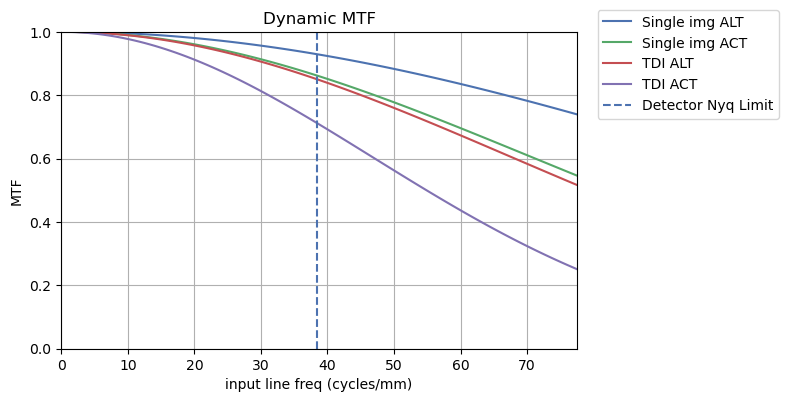

In [40]:
# Combining the Single Image Drift/Smear and Jitter(ALT)
mtf_model_single_alt = MTF_Model_1D.combined(
    mtf_model_mot_blur, mtf_model_alt_single_img_smear, mtf_model_alt_single_img_jitter
)
# Combining the TDI Image Drift/Smear and Jitter (ALT)
mtf_model_tdi_alt = MTF_Model_1D.combined(
    mtf_model_alt_tdi_line_rate_err, mtf_model_alt_tdi_smear, mtf_model_alt_tdi_jitter
)

# Combining the Single Image Drift/Smear and Jitter(ACT)
mtf_model_single_act = MTF_Model_1D.combined(
    mtf_model_act_single_img_smear, mtf_model_act_single_img_jitter
)
# Combining the TDI Image Drift/Smear and Jitter (ACT)
mtf_model_tdi_act = MTF_Model_1D.combined(
    mtf_model_act_tdi_smear, mtf_model_act_tdi_jitter
)


# plot the MTF data
# -----------------

mtf_plot_list = {
    "Single img ALT": mtf_model_single_alt,
    "Single img ACT": mtf_model_single_act,
    "TDI ALT": mtf_model_tdi_alt,
    "TDI ACT": mtf_model_tdi_act,
}

# populate the mtf plot with the models
dynamic_mtf_plot = MTF_Plot_1D(
    input_line_freq_mid, mtf_plot_list, nyq_limit=nyq_freq, acceptable_limit=None
)

# set MTF plot style tweaks
dynamic_mtf_plot.set_plot_style(x_max=input_line_freq_mid.max(), title="Dynamic MTF")


# plot the figure
# plt.show()

As the values are pretty much made up, it is not the case in this example, but the ACT and ALT Single Image MTF usually vary to a certain extent, due to the fairly large Motion Blur in the ALT direction. This is an unavoidable artefact of pushbroom sensors, as SNR requires as long as possible an exposure, whereas this also introduces a large motion blur. Exposure time can be traded off against more TDI steps, but then the ALT component of the TDI MTF starts to increase. All other things being equal, this boils down to how stable the platform is over a duration longer than the line rate: if the platform is very stable, it may be better to keep the exposures short and compensate with a lot of TDI stages. If, on the other hand, the platform is not very stable, a long exposure and few (if any TDI stages) may be the way to go. It is possible to evaluate such trade-offs using the models described above.

In this example, both the the ACT TDI and ALT TDI MTF contributions are significantly higher than the Single Image MTF, which is also usually the case for long TDI columns.

## Bringing Everything Together: Total System MTF

In the absence of atmospheric MTF modelling, the total MTF is the combination of Imager MTF and the Dynamic MTF. It can be said to be the MTF that would be measured if the satellite was looking at a target without the atmosphere in between - a usual such target is the stars.

While the Imager MTF is usually not very different in the ALT and ACT directions, the Dynamic MTF components usually are. Therefore we need to differentiate between the two when we are computing the Total or System MTF.

Below we plot the total ALT and ACT MTF, as well as the Imager MTF for comparison, to illustrate how much the Dynamic MTF degrades the Imager MTF. 

Imager MTF     : 23.208% (at Nyq Limit 38.46 cycle / mm and 650.0 nm)
System MTF ALT : 18.330% (at Nyq Limit 38.46 cycle / mm and 650.0 nm)
System MTF ACT : 14.230% (at Nyq Limit 38.46 cycle / mm and 650.0 nm)


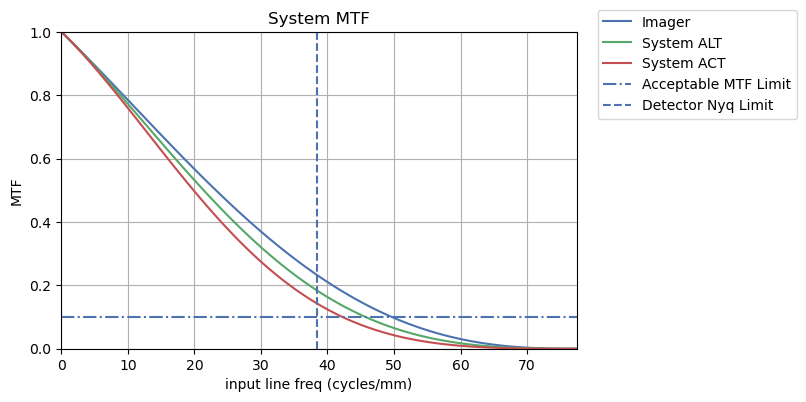

In [41]:
# compute the total system MTF in the ACT and ALT directions
mtf_model_act_sys = MTF_Model_1D.combined(
    mtf_model_imager_mid, mtf_model_single_act, mtf_model_tdi_act
)
mtf_model_alt_sys = MTF_Model_1D.combined(
    mtf_model_imager_mid, mtf_model_single_alt, mtf_model_tdi_alt
)

# plot the MTF data
# -----------------

mtf_plot_list = {
    "Imager": mtf_model_imager_mid,
    "System ALT": mtf_model_alt_sys,
    "System ACT": mtf_model_act_sys,
}

# populate the mtf plot with the models
sys_mtf_plot = MTF_Plot_1D(input_line_freq_mid, mtf_plot_list, nyq_limit=nyq_freq)


# set MTF plot style tweaks
sys_mtf_plot.set_plot_style(x_max=input_line_freq_mid.max(), title="System MTF")

print(
    f"Imager MTF     : {mtf_model_imager_mid.mtf_value(nyq_freq):.3%} (at Nyq Limit {nyq_freq:.4} and {ref_wavelength_mid})"
)
print(
    f"System MTF ALT : {mtf_model_alt_sys.mtf_value(nyq_freq):.3%} (at Nyq Limit {nyq_freq:.4} and {ref_wavelength_mid})"
)
print(
    f"System MTF ACT : {mtf_model_act_sys.mtf_value(nyq_freq):.3%} (at Nyq Limit {nyq_freq:.4} and {ref_wavelength_mid})"
)

In this example, we see that the System MTF is impacted by the Dynamic MTF contributors to a certain extent, though the sharpness degradation is dominated by the Imager MTF. Nevertheless the System MTF (though without the atmospheric effects) is still higher than 10% at the Nyquist limit.

The real star based calibration results (See Ref 1 below) suggest a PAN MTF of 15% at both ACT and ALT directions, whereas the MS MTF values are around 31% and 25% in ACT and ALT, respectively.

This sort of analysis can be useful in trading off exposure time versus the number of TDI stages. It can also be important when optimising the optical system, particularly when it is not symmetric in ALT and ACT directions - MTF is an expensive parameter when designing an optical system, be it the increased aperture, more robust design, better materials, better tolerancing or better focussing. Similarly, there may be little point in improving the Optical MTF that little bit, when the System MTF is dominated by Dynamic MTF contributors. Finally, certain platform decisions can be taken using such an analysis, such as introducing isolators to the worst vibration sources or designing attitude controllers that are less precise but smoother. That said, reliably computing or measuring the Dynamic MTF contributors is usually very difficult.

## References

1. [On-orbit star-based radiometric and spatial calibration of PLEIADES HR optical sensors](https://earth.esa.int/eogateway/documents/20142/2982981/2_AMEYGRET_VH_RODA_2019.pdf/63f00cf4-d1a6-b2ff-d692-2e35a99ef62b)
2. [First in-flight results of Pleiades 1A innovative methods for optical calibration](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/10564/2309056/First-in-flight-results-of-Pleiades-1A-innovative-methods-for/10.1117/12.2309056.full)
3. [Attitude assessment using Pléiades-HR capabilities](https://isprs-archives.copernicus.org/articles/XXXIX-B1/525/2012/isprsarchives-XXXIX-B1-525-2012.pdf)
4. [Star-based methods for Pleiades-HR commissioning](https://isprs-archives.copernicus.org/articles/XXXIX-B1/531/2012/isprsarchives-XXXIX-B1-531-2012.pdf)
5. [Pleiades-HR Innovative Techniques for Radiometric Image Quality Commissioning](https://isprs-archives.copernicus.org/articles/XXXIX-B1/543/2012/isprsarchives-XXXIX-B1-543-2012.pdf)
6. [Pleiades HR in flight geometrical calibration: Localisation and mapping of the focal plane](https://isprs-archives.copernicus.org/articles/XXXIX-B1/519/2012/isprsarchives-XXXIX-B1-519-2012.pdf)
7. [Pleiades-HR image quality commissioning](https://isprs-archives.copernicus.org/articles/XXXIX-B1/561/2012/isprsarchives-XXXIX-B1-561-2012.pdf)